In [37]:
# Import necessary packages
import os
import sys
import random
import warnings
import math
import re
from tqdm import tqdm
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerEncoder

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set parameters
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

TRAIN_PATH = './data/065'
TEST_PATH = './data/065'


In [38]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
num_test_items = int(0.1 * len(train_ids))

# Slice the train_ids list to get the test IDs
test_ids = train_ids[-num_test_items:]


In [39]:

sequences = {}
masks = {}
time_steps_list = []

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train_1 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train_2 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    
    # Extract time step 
    match = re.search(r'_i(\d+)_', id_)
    if match:
        time_step = int(match.group(1))
    else:
        raise ValueError(f"Time step not found in the filename: {id_}")
    time_steps_list.append(time_step)
    
    img_path = os.path.join(path, 'images', id_ + '_mSLIM' + '.png')
    img = imread(img_path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis=-1).astype(np.float64)
    X_train[n] = img.astype(np.float64)
    
    # Load masks
    for mask_file in next(os.walk(os.path.join(path, 'masks/')))[2]:
        mask = imread(os.path.join(path, 'masks', mask_file))
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        if mask_file.endswith('Prot.png'):
            Y_train_2[n] = np.where(mask[:, :, np.newaxis] > 0, 2, 0)
        else:
            Y_train_1[n] = np.where(mask[:, :, np.newaxis] > 0, 1, 0)

    Y_train[n] = np.maximum(Y_train_1[n], Y_train_2[n])
    
    if time_step not in sequences:
        sequences[time_step] = []
        masks[time_step] = []
    sequences[time_step].append(img)
    masks[time_step].append(Y_train[n])

# Sort sequences by time steps
time_steps = sorted(sequences.keys())
X_sequences = [np.stack(sequences[t]) for t in time_steps]
Y_sequences = [np.stack(masks[t]) for t in time_steps]

X_sequences = np.array(X_sequences)  
Y_sequences = np.array(Y_sequences)


Getting and resizing train images and masks ... 


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [40]:

print('Data loaded and resized.')
split_ratio = 0.8
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0] * test_ratio)

X_test = x_val[split_test:]
Y_test = y_val[split_test:]
x_val = x_val[:split_test]
y_val = y_val[:split_test]

x_train_tensor = torch.from_numpy(x).float()
y_train_tensor = torch.from_numpy(y).float()

x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

x_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(Y_test).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


Data loaded and resized.


In [41]:

def show_mask(mask, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


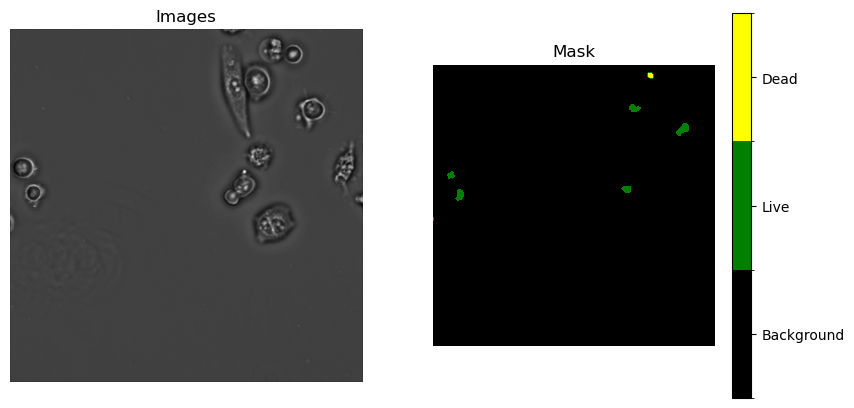

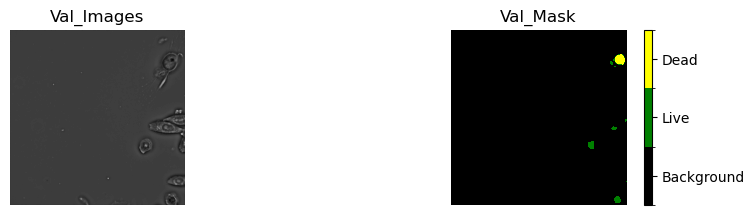

In [42]:

import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[5,:,:,0], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
show_mask(y[5],"Mask")

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(x_val[5,:,:,0], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
show_mask(y_val[5],"Val_Mask")
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)


In [43]:

# Define IoU metric
import torch

def mean_iou(y_pred, y_true, num_classes=3):
    
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []
    
    for class_id in range(num_classes):
       
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
        
        if union == 0:
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        iou_list.append(iou)

    return torch.mean(torch.tensor(iou_list))



In [44]:


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = SelfAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = SelfAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = SelfAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = SelfAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = SelfAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = SelfAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        #x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        #x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        #x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        #x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        #x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        #x = self.self_attention6(x)
        output = self.output_conv(x)
        return output
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True, name="null"):
        self.patience = patience
        self.verbose = verbose
        self.name = name
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), f'checkpoint_{self.name}.pth')


In [45]:
import torch.backends.cudnn as cudnn

c_in = 3  # input channel 3 for RGB
c_out = 3  # output channel
if torch.cuda.device_count() > 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('checkpoint.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
cudnn.benchmark = True
model = torch.nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# early_stopping = EarlyStopping(patience=5, verbose=True, name="unet")
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

/home/chenzhong/miniconda3/envs/anzhe/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [46]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


def calculate_metrics(y_true, y_pred):
    # Flatten the predictions and true labels to compute pixel-wise values
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[1, 2])
    precision = precision_score(y_true_flat, y_pred_flat, labels=[1, 2], average=None)
    recall = recall_score(y_true_flat, y_pred_flat, labels=[1, 2], average=None)
    f1 = f1_score(y_true_flat, y_pred_flat, labels=[1, 2], average=None)

    return cm, precision, recall, f1

In [47]:

# Training loop
num_epochs = 100
model.to(device1)
best_loss = 1.0
best_iou = 0.0
train_predictions = []
train_labels = []
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    train_predictions.clear()
    train_labels.clear()
    for i,(inputs, labels) in enumerate(tqdm(train_loader)):
        gpu = torch.cuda.get_device_properties(device1)
        #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
        #print(torch.cuda.memory_allocated(device1))
        #print(torch.cuda.max_memory_allocated(device1))
        if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
            model = model.to(device2)
            device1, device2 = device2, device1
            print('changed gpu')
            #inputs, labels = inputs.to(device1), labels.to(device1)
            model = model.to(device1)
            
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        #print(inputs.shape)
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        iou = mean_iou(outputs, labels)
        labels = labels.long()
        # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()
        preds = torch.argmax(outputs, dim=1)
        train_predictions.append(preds.cpu().numpy())
        train_labels.append(labels.cpu().numpy())
        # if i % 50 == 0 and i != 0:
        #     print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
        #     if i % 100 == 0:
        #         print(f'Saving model...')
        #         torch.save(model.state_dict(), 'checkpoint_unet.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)

    y_true = np.concatenate(train_labels, axis=0)
    y_pred = np.concatenate(train_predictions, axis=0)
    cm, precision, recall, f1 = calculate_metrics(y_true, y_pred)

    # Print metrics
    print("\nTraining Metrics for Epoch [{}]:".format(epoch + 1))
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision (Live, Dead): {precision * 100}%")
    print(f"Recall (Live, Dead): {recall * 100}%")
    print(f"F1 Score (Live, Dead): {f1 * 100}%\n")
    
    # if early_stopping(avg_loss, model):
    #     print('Early stopping triggered')
    # break
    
# torch.save(model.state_dict(), 'model.pth')
print(f'Best loss is {best_loss}, best iou is {best_iou}')


100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [1/100] Loss: 0.009959280356997623 IoU: 0.7096874192357063

Training Metrics for Epoch [1]:
Confusion Matrix:
[[76219  3540]
 [ 1398 79354]]
Precision (Live, Dead): [82.91884247 81.69370779]%
Recall (Live, Dead): [72.99971267 79.01266529]%
F1 Score (Live, Dead): [77.64376305 80.33082281]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [2/100] Loss: 0.011716790439095348 IoU: 0.684424240142107

Training Metrics for Epoch [2]:
Confusion Matrix:
[[70520  4663]
 [  861 77328]]
Precision (Live, Dead): [77.50387409 77.01224978]%
Recall (Live, Dead): [67.54142324 76.99537996]%
F1 Score (Live, Dead): [72.18051269 77.00381394]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [3/100] Loss: 0.01025533540523611 IoU: 0.7057735733687878

Training Metrics for Epoch [3]:
Confusion Matrix:
[[74589  4640]
 [  975 79725]]
Precision (Live, Dead): [80.23773666 80.51485069]%
Recall (Live, Dead): [71.43855952 79.38206946]%
F1 Score (Live, Dead): [75.58291534 79.94444751]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [4/100] Loss: 0.008663349626294803 IoU: 0.7358315382152796

Training Metrics for Epoch [4]:
Confusion Matrix:
[[75437  4242]
 [ 1037 84079]]
Precision (Live, Dead): [84.11047186 83.67734873]%
Recall (Live, Dead): [72.25074227 83.71734109]%
F1 Score (Live, Dead): [77.730837   83.69734013]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [5/100] Loss: 0.007265865019871853 IoU: 0.7716529481112957

Training Metrics for Epoch [5]:
Confusion Matrix:
[[81212  4269]
 [ 1052 87700]]
Precision (Live, Dead): [84.13048658 85.84321134]%
Recall (Live, Dead): [77.78182166 87.32276565]%
F1 Score (Live, Dead): [80.83168691 86.57666774]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [6/100] Loss: 0.0066433709871489555 IoU: 0.7847408253699542

Training Metrics for Epoch [6]:
Confusion Matrix:
[[84580  3587]
 [ 1384 87479]]
Precision (Live, Dead): [86.18915146 86.13359327]%
Recall (Live, Dead): [81.00756633 87.10271627]%
F1 Score (Live, Dead): [83.51806777 86.61544402]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [7/100] Loss: 0.006588011547864881 IoU: 0.7947149395942688

Training Metrics for Epoch [7]:
Confusion Matrix:
[[84515  4190]
 [ 1436 88146]]
Precision (Live, Dead): [87.25119756 85.5911055 ]%
Recall (Live, Dead): [80.94531175 87.76684722]%
F1 Score (Live, Dead): [83.9800471  86.66532296]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [8/100] Loss: 0.006351883223396726 IoU: 0.7852905634790659

Training Metrics for Epoch [8]:
Confusion Matrix:
[[84376  4184]
 [ 1259 89271]]
Precision (Live, Dead): [85.76714306 86.69444121]%
Recall (Live, Dead): [80.81218274 88.88700812]%
F1 Score (Live, Dead): [83.21596939 87.77703487]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [9/100] Loss: 0.0063179344768286684 IoU: 0.7945703364908695

Training Metrics for Epoch [9]:
Confusion Matrix:
[[85148  3672]
 [ 1638 87504]]
Precision (Live, Dead): [86.14382259 87.36072841]%
Recall (Live, Dead): [81.55157552 87.12760873]%
F1 Score (Live, Dead): [83.78482096 87.24401284]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [10/100] Loss: 0.005988956561486703 IoU: 0.8014452159404755

Training Metrics for Epoch [10]:
Confusion Matrix:
[[86782  4159]
 [ 1154 89705]]
Precision (Live, Dead): [87.37087973 85.75429943]%
Recall (Live, Dead): [83.11655972 89.31914131]%
F1 Score (Live, Dead): [85.19063887 87.50042675]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [11/100] Loss: 0.005588553065899759 IoU: 0.8204239182174206

Training Metrics for Epoch [11]:
Confusion Matrix:
[[87654  3185]
 [ 1698 90145]]
Precision (Live, Dead): [87.51572515 87.43792194]%
Recall (Live, Dead): [83.95172876 89.75724869]%
F1 Score (Live, Dead): [85.69668765 88.58240635]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [12/100] Loss: 0.005998900164559018 IoU: 0.8003923192620277

Training Metrics for Epoch [12]:
Confusion Matrix:
[[86746  3667]
 [ 1225 88321]]
Precision (Live, Dead): [87.56119472 87.12649574]%
Recall (Live, Dead): [83.08208026 87.94109447]%
F1 Score (Live, Dead): [85.26285268 87.53189992]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [13/100] Loss: 0.0052035136468475685 IoU: 0.8202607594430447

Training Metrics for Epoch [13]:
Confusion Matrix:
[[88568  2687]
 [ 1477 91338]]
Precision (Live, Dead): [87.32105533 89.44708855]%
Recall (Live, Dead): [84.82712384 90.94511709]%
F1 Score (Live, Dead): [86.05602464 90.18988279]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [14/100] Loss: 0.005037379454006441 IoU: 0.8281238190829754

Training Metrics for Epoch [14]:
Confusion Matrix:
[[87804  3167]
 [ 1108 92290]]
Precision (Live, Dead): [87.74696447 90.37849483]%
Recall (Live, Dead): [84.09539316 91.89302214]%
F1 Score (Live, Dead): [85.88238171 91.12946625]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [15/100] Loss: 0.005574803655326832 IoU: 0.8179226346313954

Training Metrics for Epoch [15]:
Confusion Matrix:
[[87987  3460]
 [ 1553 89777]]
Precision (Live, Dead): [87.8420606  87.40313096]%
Recall (Live, Dead): [84.27066373 89.39083161]%
F1 Score (Live, Dead): [86.01930832 88.38580739]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [16/100] Loss: 0.005703464245016221 IoU: 0.814779207855463

Training Metrics for Epoch [16]:
Confusion Matrix:
[[88284  2718]
 [ 1619 88887]]
Precision (Live, Dead): [87.55987979 87.82172251]%
Recall (Live, Dead): [84.55511924 88.50465987]%
F1 Score (Live, Dead): [86.03127116 88.16186863]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [17/100] Loss: 0.004794538592977915 IoU: 0.8357958726584911

Training Metrics for Epoch [17]:
Confusion Matrix:
[[89657  3098]
 [  784 93138]]
Precision (Live, Dead): [88.94808377 89.42421246]%
Recall (Live, Dead): [85.87012738 92.73737454]%
F1 Score (Live, Dead): [87.38200939 91.05066354]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [18/100] Loss: 0.0046754538532695735 IoU: 0.8401968583464623

Training Metrics for Epoch [18]:
Confusion Matrix:
[[89221  2448]
 [ 1390 92169]]
Precision (Live, Dead): [88.22843016 91.62019503]%
Recall (Live, Dead): [85.45254286 91.77254262]%
F1 Score (Live, Dead): [86.81830345 91.69630554]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [19/100] Loss: 0.004239099952974357 IoU: 0.8559394598007202

Training Metrics for Epoch [19]:
Confusion Matrix:
[[90769  2598]
 [ 1330 93795]]
Precision (Live, Dead): [89.46196075 91.1400892 ]%
Recall (Live, Dead): [86.93515947 93.39154851]%
F1 Score (Live, Dead): [88.18046252 92.2520839 ]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [20/100] Loss: 0.004257609724299982 IoU: 0.8522579677402973

Training Metrics for Epoch [20]:
Confusion Matrix:
[[90785  2583]
 [ 1497 93795]]
Precision (Live, Dead): [88.58628832 91.94236142]%
Recall (Live, Dead): [86.95048367 93.39154851]%
F1 Score (Live, Dead): [87.76076407 92.66128913]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [21/100] Loss: 0.004036738058493939 IoU: 0.8590325325727463

Training Metrics for Epoch [21]:
Confusion Matrix:
[[90654  2369]
 [ 1146 94426]]
Precision (Live, Dead): [89.01785188 92.7937578 ]%
Recall (Live, Dead): [86.82501676 94.01983432]%
F1 Score (Live, Dead): [87.90776153 93.40277263]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [22/100] Loss: 0.003980524893268012 IoU: 0.8622682243585587

Training Metrics for Epoch [22]:
Confusion Matrix:
[[91674  2147]
 [ 1509 93664]]
Precision (Live, Dead): [89.36829791 92.21892938]%
Recall (Live, Dead): [87.80193468 93.261112  ]%
F1 Score (Live, Dead): [88.57819218 92.73709276]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [23/100] Loss: 0.003650151519832434 IoU: 0.8693641066551209

Training Metrics for Epoch [23]:
Confusion Matrix:
[[93808  2242]
 [ 1153 94330]]
Precision (Live, Dead): [89.74780912 92.70215024]%
Recall (Live, Dead): [89.84580021 93.92424725]%
F1 Score (Live, Dead): [89.79677793 93.30919738]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [24/100] Loss: 0.0037772871655761264 IoU: 0.8681908071041107

Training Metrics for Epoch [24]:
Confusion Matrix:
[[92394  1919]
 [ 1696 93982]]
Precision (Live, Dead): [89.65329866 92.92635659]%
Recall (Live, Dead): [88.4915238  93.57774415]%
F1 Score (Live, Dead): [89.06862296 93.25091284]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [25/100] Loss: 0.003790750694315648 IoU: 0.8669419266283512

Training Metrics for Epoch [25]:
Confusion Matrix:
[[92233  2203]
 [ 1294 93875]]
Precision (Live, Dead): [89.95445369 92.8471817 ]%
Recall (Live, Dead): [88.33732401 93.4712044 ]%
F1 Score (Live, Dead): [89.13855506 93.15814805]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [26/100] Loss: 0.0036019706472870893 IoU: 0.8705074720084667

Training Metrics for Epoch [26]:
Confusion Matrix:
[[92987  2218]
 [ 1055 94455]]
Precision (Live, Dead): [90.44460223 92.80675208]%
Recall (Live, Dead): [89.05947706 94.04870957]%
F1 Score (Live, Dead): [89.74669556 93.42360342]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [27/100] Loss: 0.0035516573996574154 IoU: 0.8743407361209392

Training Metrics for Epoch [27]:
Confusion Matrix:
[[93664  1998]
 [ 1690 94175]]
Precision (Live, Dead): [90.20725788 92.83538539]%
Recall (Live, Dead): [89.70788239 93.76991397]%
F1 Score (Live, Dead): [89.95687709 93.3003096 ]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [28/100] Loss: 0.003410234560578829 IoU: 0.8708835765719414

Training Metrics for Epoch [28]:
Confusion Matrix:
[[93474  2088]
 [ 1364 94324]]
Precision (Live, Dead): [90.99085945 92.81757083]%
Recall (Live, Dead): [89.52590748 93.91827306]%
F1 Score (Live, Dead): [90.25243918 93.36467793]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [29/100] Loss: 0.0033471900227596053 IoU: 0.8781214497983456

Training Metrics for Epoch [29]:
Confusion Matrix:
[[94248  2012]
 [ 1236 94534]]
Precision (Live, Dead): [91.07406871 93.07642321]%
Recall (Live, Dead): [90.26721578 94.12736976]%
F1 Score (Live, Dead): [90.66884725 93.59894652]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [30/100] Loss: 0.0035463340049318504 IoU: 0.8724101074039936

Training Metrics for Epoch [30]:
Confusion Matrix:
[[92939  2294]
 [ 1279 94940]]
Precision (Live, Dead): [89.5693992  93.16885997]%
Recall (Live, Dead): [89.01350445 94.53162339]%
F1 Score (Live, Dead): [89.29058663 93.84529464]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [31/100] Loss: 0.0033348943754390346 IoU: 0.879585075378418

Training Metrics for Epoch [31]:
Confusion Matrix:
[[93578  1622]
 [ 1345 95048]]
Precision (Live, Dead): [90.51935113 94.20113182]%
Recall (Live, Dead): [89.6255148  94.63915883]%
F1 Score (Live, Dead): [90.07021546 94.41963731]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [32/100] Loss: 0.0031635353443562053 IoU: 0.8869151033461093

Training Metrics for Epoch [32]:
Confusion Matrix:
[[94358  1771]
 [ 1099 95347]]
Precision (Live, Dead): [91.07915058 93.94070761]%
Recall (Live, Dead): [90.37256968 94.93687271]%
F1 Score (Live, Dead): [90.7244844  94.43616321]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [33/100] Loss: 0.003111396524036536 IoU: 0.8881615422666073

Training Metrics for Epoch [33]:
Confusion Matrix:
[[94615  1820]
 [ 1072 95350]]
Precision (Live, Dead): [91.06527556 94.00942559]%
Recall (Live, Dead): [90.61871468 94.93985981]%
F1 Score (Live, Dead): [90.84144632 94.47235185]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [34/100] Loss: 0.0030850704861222766 IoU: 0.8899284534156322

Training Metrics for Epoch [34]:
Confusion Matrix:
[[95115  1765]
 [ 1428 95086]]
Precision (Live, Dead): [91.17618865 93.73435066]%
Recall (Live, Dead): [91.09759602 94.67699538]%
F1 Score (Live, Dead): [91.13687539 94.20331494]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [35/100] Loss: 0.0035032303727348334 IoU: 0.8762408182024956

Training Metrics for Epoch [35]:
Confusion Matrix:
[[94651  1842]
 [ 1291 93283]]
Precision (Live, Dead): [91.41138067 92.55184046]%
Recall (Live, Dead): [90.65319414 92.88175084]%
F1 Score (Live, Dead): [91.03070871 92.71650217]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [36/100] Loss: 0.0035322123003425077 IoU: 0.872959130257368

Training Metrics for Epoch [36]:
Confusion Matrix:
[[94383  2254]
 [ 1311 93553]]
Precision (Live, Dead): [91.0461583  91.81223993]%
Recall (Live, Dead): [90.39651374 93.15058945]%
F1 Score (Live, Dead): [90.72017301 92.47657269]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [37/100] Loss: 0.003610801672039088 IoU: 0.8706786826252937

Training Metrics for Epoch [37]:
Confusion Matrix:
[[93793  1675]
 [ 1979 93024]]
Precision (Live, Dead): [90.41596375 92.79942539]%
Recall (Live, Dead): [89.83143377 92.6238649 ]%
F1 Score (Live, Dead): [90.12275097 92.71156204]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [38/100] Loss: 0.00330899538093945 IoU: 0.8839373715221882

Training Metrics for Epoch [38]:
Confusion Matrix:
[[94417  2255]
 [ 1305 94335]]
Precision (Live, Dead): [91.49998062 92.53882148]%
Recall (Live, Dead): [90.42907767 93.92922574]%
F1 Score (Live, Dead): [90.96137728 93.22883982]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [39/100] Loss: 0.0027663406173815018 IoU: 0.900624118000269

Training Metrics for Epoch [39]:
Confusion Matrix:
[[95785  1845]
 [ 1203 95660]]
Precision (Live, Dead): [92.19670427 94.33273837]%
Recall (Live, Dead): [91.739297   95.24852637]%
F1 Score (Live, Dead): [91.9674319  94.78842047]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [40/100] Loss: 0.0026623470566846663 IoU: 0.9030376493930816

Training Metrics for Epoch [40]:
Confusion Matrix:
[[95819  1734]
 [ 1128 96105]]
Precision (Live, Dead): [92.26495397 94.64370125]%
Recall (Live, Dead): [91.77186093 95.69161224]%
F1 Score (Live, Dead): [92.01774688 95.16477205]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [41/100] Loss: 0.002742716475768248 IoU: 0.9004001043736934

Training Metrics for Epoch [41]:
Confusion Matrix:
[[95846  1451]
 [ 1185 95991]]
Precision (Live, Dead): [91.89629715 94.91842183]%
Recall (Live, Dead): [91.79772052 95.5781026 ]%
F1 Score (Live, Dead): [91.84698239 95.24711999]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [42/100] Loss: 0.00249841977347387 IoU: 0.9046716943383217

Training Metrics for Epoch [42]:
Confusion Matrix:
[[97117  1544]
 [ 1047 96112]]
Precision (Live, Dead): [92.81324962 94.79809836]%
Recall (Live, Dead): [93.01503687 95.69858213]%
F1 Score (Live, Dead): [92.91403369 95.24621193]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [43/100] Loss: 0.0027324809263518544 IoU: 0.8995631158351898

Training Metrics for Epoch [43]:
Confusion Matrix:
[[96052  1457]
 [ 1242 95560]]
Precision (Live, Dead): [92.37989901 94.73955545]%
Recall (Live, Dead): [91.99501963 95.14895651]%
F1 Score (Live, Dead): [92.18705761 94.94381464]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [44/100] Loss: 0.00285942886112025 IoU: 0.8950507171452046

Training Metrics for Epoch [44]:
Confusion Matrix:
[[95421  1565]
 [ 1437 95541]]
Precision (Live, Dead): [91.65578054 94.57725774]%
Recall (Live, Dead): [91.39067139 95.13003823]%
F1 Score (Live, Dead): [91.52303398 94.85284263]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [45/100] Loss: 0.0028766821706085466 IoU: 0.8932787127792835

Training Metrics for Epoch [45]:
Confusion Matrix:
[[95288  1825]
 [ 1118 96059]]
Precision (Live, Dead): [91.21174703 94.4932469 ]%
Recall (Live, Dead): [91.26328896 95.6458101 ]%
F1 Score (Live, Dead): [91.23751071 95.06603526]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [46/100] Loss: 0.00269455123852822 IoU: 0.9002910867333412

Training Metrics for Epoch [46]:
Confusion Matrix:
[[96479  1538]
 [ 1537 95439]]
Precision (Live, Dead): [91.94693555 94.71725452]%
Recall (Live, Dead): [92.40398429 95.02847698]%
F1 Score (Live, Dead): [92.17489335 94.87261052]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [47/100] Loss: 0.002525665563007351 IoU: 0.9063378393650054

Training Metrics for Epoch [47]:
Confusion Matrix:
[[96520  1602]
 [  844 96132]]
Precision (Live, Dead): [93.18941047 94.77575889]%
Recall (Live, Dead): [92.44325256 95.7184961 ]%
F1 Score (Live, Dead): [92.81483191 95.24479474]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [48/100] Loss: 0.0023305267852265386 IoU: 0.9120087049901485

Training Metrics for Epoch [48]:
Confusion Matrix:
[[97189  1348]
 [ 1061 96569]]
Precision (Live, Dead): [92.93001731 95.34289043]%
Recall (Live, Dead): [93.08399579 96.15361638]%
F1 Score (Live, Dead): [93.00694282 95.74653725]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [49/100] Loss: 0.002350260905950563 IoU: 0.910924369096756

Training Metrics for Epoch [49]:
Confusion Matrix:
[[97134  1477]
 [ 1180 96553]]
Precision (Live, Dead): [93.15533562 95.00255825]%
Recall (Live, Dead): [93.03131884 96.1376852 ]%
F1 Score (Live, Dead): [93.09328592 95.56675113]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [50/100] Loss: 0.0025445905768719966 IoU: 0.9071140095591546

Training Metrics for Epoch [50]:
Confusion Matrix:
[[96716  1815]
 [ 1181 95666]]
Precision (Live, Dead): [93.00509664 94.87098118]%
Recall (Live, Dead): [92.63097404 95.25450056]%
F1 Score (Live, Dead): [92.81765835 95.06235405]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [51/100] Loss: 0.002611819801677484 IoU: 0.9040388375520706

Training Metrics for Epoch [51]:
Confusion Matrix:
[[96746  1587]
 [ 1444 95504]]
Precision (Live, Dead): [92.3571865  94.64837866]%
Recall (Live, Dead): [92.65970692 95.09319739]%
F1 Score (Live, Dead): [92.50819939 94.87026662]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [52/100] Loss: 0.002346466505332501 IoU: 0.9101689577102661

Training Metrics for Epoch [52]:
Confusion Matrix:
[[96913  1426]
 [ 1124 96492]]
Precision (Live, Dead): [93.2797536  95.33746332]%
Recall (Live, Dead): [92.81965329 96.07694759]%
F1 Score (Live, Dead): [93.04913468 95.70577704]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [53/100] Loss: 0.0022484966400952546 IoU: 0.9156076952815055

Training Metrics for Epoch [53]:
Confusion Matrix:
[[97542  1385]
 [  879 96831]]
Precision (Live, Dead): [93.19180647 95.75092952]%
Recall (Live, Dead): [93.42208601 96.41448941]%
F1 Score (Live, Dead): [93.30680416 96.0815638 ]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [54/100] Loss: 0.0022861802488478135 IoU: 0.9131874404847622

Training Metrics for Epoch [54]:
Confusion Matrix:
[[97368  1342]
 [ 1251 96580]]
Precision (Live, Dead): [93.04512356 95.66543841]%
Recall (Live, Dead): [93.2554353  96.16456906]%
F1 Score (Live, Dead): [93.15016072 95.91435438]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [55/100] Loss: 0.002335068142201635 IoU: 0.9134014584124088

Training Metrics for Epoch [55]:
Confusion Matrix:
[[97154  1286]
 [ 1029 96492]]
Precision (Live, Dead): [93.07632615 95.77845054]%
Recall (Live, Dead): [93.05047409 96.07694759]%
F1 Score (Live, Dead): [93.06339833 95.92746686]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [56/100] Loss: 0.0023629744646314066 IoU: 0.9100426755845547

Training Metrics for Epoch [56]:
Confusion Matrix:
[[97084  1318]
 [  983 96601]]
Precision (Live, Dead): [92.88823828 95.4432731 ]%
Recall (Live, Dead): [92.98343071 96.18547873]%
F1 Score (Live, Dead): [92.93581012 95.81293858]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [57/100] Loss: 0.002447785041294992 IoU: 0.9096407316625118

Training Metrics for Epoch [57]:
Confusion Matrix:
[[97260  1423]
 [ 1114 95797]]
Precision (Live, Dead): [93.05930306 95.08670233]%
Recall (Live, Dead): [93.15199694 95.38493707]%
F1 Score (Live, Dead): [93.10562693 95.23558622]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [58/100] Loss: 0.002254462140626856 IoU: 0.9168743759393692

Training Metrics for Epoch [58]:
Confusion Matrix:
[[97392  1304]
 [  943 96598]]
Precision (Live, Dead): [93.77058019 95.87224709]%
Recall (Live, Dead): [93.27842161 96.18249164]%
F1 Score (Live, Dead): [93.52385342 96.02711878]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [59/100] Loss: 0.0021326046160538683 IoU: 0.9193585827946663

Training Metrics for Epoch [59]:
Confusion Matrix:
[[98163  1401]
 [ 1125 97035]]
Precision (Live, Dead): [93.50014764 95.55391433]%
Recall (Live, Dead): [94.01685662 96.61761192]%
F1 Score (Live, Dead): [93.75779023 96.08281926]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [60/100] Loss: 0.002123048359135282 IoU: 0.9204207383096218

Training Metrics for Epoch [60]:
Confusion Matrix:
[[97943  1439]
 [ 1254 96403]]
Precision (Live, Dead): [93.70204542 95.85757042]%
Recall (Live, Dead): [93.80614884 95.98833041]%
F1 Score (Live, Dead): [93.75406823 95.92290586]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [61/100] Loss: 0.0021603075030725448 IoU: 0.9182557217776776

Training Metrics for Epoch [61]:
Confusion Matrix:
[[97954  1455]
 [ 1075 96438]]
Precision (Live, Dead): [93.91382716 95.38778054]%
Recall (Live, Dead): [93.81668423 96.02317986]%
F1 Score (Live, Dead): [93.86523056 95.70442558]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [62/100] Loss: 0.002604612240975257 IoU: 0.9036647185683251

Training Metrics for Epoch [62]:
Confusion Matrix:
[[97145  1449]
 [ 1430 95418]]
Precision (Live, Dead): [93.14801853 94.06997723]%
Recall (Live, Dead): [93.04185423 95.00756731]%
F1 Score (Live, Dead): [93.09490611 94.53644763]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [63/100] Loss: 0.0023041131888021484 IoU: 0.9088659942150116

Training Metrics for Epoch [63]:
Confusion Matrix:
[[97755  1544]
 [ 1119 95927]]
Precision (Live, Dead): [93.6144336  95.09209144]%
Recall (Live, Dead): [93.62608946 95.51437789]%
F1 Score (Live, Dead): [93.62026117 95.30276688]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [64/100] Loss: 0.002074521758913761 IoU: 0.9204230077564717

Training Metrics for Epoch [64]:
Confusion Matrix:
[[98229  1174]
 [  953 96733]]
Precision (Live, Dead): [94.11071511 95.7430172 ]%
Recall (Live, Dead): [94.08006896 96.31691094]%
F1 Score (Live, Dead): [94.09538954 96.02910665]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [65/100] Loss: 0.0019194438395061298 IoU: 0.9266361087560654

Training Metrics for Epoch [65]:
Confusion Matrix:
[[98542  1218]
 [  812 97351]]
Precision (Live, Dead): [94.30939438 96.14343841]%
Recall (Live, Dead): [94.37984867 96.93225267]%
F1 Score (Live, Dead): [94.34460837 96.53623418]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [66/100] Loss: 0.002023679825651925 IoU: 0.9260953582823277

Training Metrics for Epoch [66]:
Confusion Matrix:
[[98188  1170]
 [ 1086 96871]]
Precision (Live, Dead): [93.92745083 96.1966614 ]%
Recall (Live, Dead): [94.04080069 96.45431735]%
F1 Score (Live, Dead): [93.98409158 96.32531708]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [67/100] Loss: 0.002153141649978352 IoU: 0.9208229996263981

Training Metrics for Epoch [67]:
Confusion Matrix:
[[97932  1582]
 [ 1163 96452]]
Precision (Live, Dead): [93.74084674 95.49892077]%
Recall (Live, Dead): [93.79561345 96.03711964]%
F1 Score (Live, Dead): [93.7682221  95.76726406]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [68/100] Loss: 0.0020500901049672394 IoU: 0.9240966029465199

Training Metrics for Epoch [68]:
Confusion Matrix:
[[98424  1327]
 [ 1066 96881]]
Precision (Live, Dead): [93.81576941 95.76249407]%
Recall (Live, Dead): [94.26683268 96.46427433]%
F1 Score (Live, Dead): [94.04076017 96.11210317]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [69/100] Loss: 0.00190475596646138 IoU: 0.9282844416797161

Training Metrics for Epoch [69]:
Confusion Matrix:
[[98669  1184]
 [  946 97144]]
Precision (Live, Dead): [94.55491562 96.08419137]%
Recall (Live, Dead): [94.50148453 96.72614306]%
F1 Score (Live, Dead): [94.52819253 96.40409854]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [70/100] Loss: 0.0018039339698589173 IoU: 0.9317206181585789

Training Metrics for Epoch [70]:
Confusion Matrix:
[[98845  1218]
 [  781 97482]]
Precision (Live, Dead): [94.64648206 96.44425976]%
Recall (Live, Dead): [94.67005076 97.06268918]%
F1 Score (Live, Dead): [94.65826494 96.75248625]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [71/100] Loss: 0.001994354535054299 IoU: 0.9269342593848705

Training Metrics for Epoch [71]:
Confusion Matrix:
[[98471  1130]
 [ 1056 97059]]
Precision (Live, Dead): [94.19096266 96.09326271]%
Recall (Live, Dead): [94.31184752 96.64150868]%
F1 Score (Live, Dead): [94.25136633 96.36660594]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [72/100] Loss: 0.0018604084023536415 IoU: 0.9290428213775158

Training Metrics for Epoch [72]:
Confusion Matrix:
[[98670  1140]
 [  882 97311]]
Precision (Live, Dead): [94.44635883 96.42963315]%
Recall (Live, Dead): [94.50244229 96.89242473]%
F1 Score (Live, Dead): [94.47439224 96.660475  ]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [73/100] Loss: 0.001933292017201893 IoU: 0.9269741326570511

Training Metrics for Epoch [73]:
Confusion Matrix:
[[98541  1092]
 [  839 97376]]
Precision (Live, Dead): [94.21376192 96.28889834]%
Recall (Live, Dead): [94.37889091 96.95714513]%
F1 Score (Live, Dead): [94.29625412 96.62186633]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [74/100] Loss: 0.0018105399496562314 IoU: 0.9324408069252967

Training Metrics for Epoch [74]:
Confusion Matrix:
[[98833  1112]
 [  839 97469]]
Precision (Live, Dead): [94.4893257  96.68872201]%
Recall (Live, Dead): [94.65855761 97.0497451 ]%
F1 Score (Live, Dead): [94.57386595 96.86889718]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [75/100] Loss: 0.0018511615722673013 IoU: 0.9289034567773342

Training Metrics for Epoch [75]:
Confusion Matrix:
[[98839  1282]
 [ 1094 97044]]
Precision (Live, Dead): [94.36064384 96.28718274]%
Recall (Live, Dead): [94.66430419 96.6265732 ]%
F1 Score (Live, Dead): [94.51223011 96.45657943]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [76/100] Loss: 0.0018137964852940058 IoU: 0.9320546217262745

Training Metrics for Epoch [76]:
Confusion Matrix:
[[98953  1145]
 [  997 97312]]
Precision (Live, Dead): [94.61762062 96.34183769]%
Recall (Live, Dead): [94.77348913 96.89342042]%
F1 Score (Live, Dead): [94.69549074 96.61684182]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [77/100] Loss: 0.0016513848848262569 IoU: 0.9382377177476883

Training Metrics for Epoch [77]:
Confusion Matrix:
[[99421  1036]
 [  832 97660]]
Precision (Live, Dead): [94.98428409 96.75821345]%
Recall (Live, Dead): [95.22172206 97.23992353]%
F1 Score (Live, Dead): [95.10285487 96.99847043]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [78/100] Loss: 0.0017604313958145212 IoU: 0.9339539475739003

Training Metrics for Epoch [78]:
Confusion Matrix:
[[98879  1121]
 [  956 97439]]
Precision (Live, Dead): [94.66090986 96.66855164]%
Recall (Live, Dead): [94.70261469 97.01987414]%
F1 Score (Live, Dead): [94.68175768 96.84389427]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [79/100] Loss: 0.0018275088212249102 IoU: 0.9317078866064549

Training Metrics for Epoch [79]:
Confusion Matrix:
[[98835   942]
 [  912 97333]]
Precision (Live, Dead): [94.38926559 96.7303698 ]%
Recall (Live, Dead): [94.66047313 96.91433009]%
F1 Score (Live, Dead): [94.52467483 96.82226256]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [80/100] Loss: 0.001722384151435108 IoU: 0.9340616300702095

Training Metrics for Epoch [80]:
Confusion Matrix:
[[99136  1107]
 [  757 97609]]
Precision (Live, Dead): [94.9487597  96.52025156]%
Recall (Live, Dead): [94.9487597 97.1891429]%
F1 Score (Live, Dead): [94.9487597  96.85354237]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [81/100] Loss: 0.0016038520912843523 IoU: 0.9381245851516724

Training Metrics for Epoch [81]:
Confusion Matrix:
[[99691  1032]
 [  821 97538]]
Precision (Live, Dead): [95.05425351 97.02087872]%
Recall (Live, Dead): [95.48031798 97.1184483 ]%
F1 Score (Live, Dead): [95.26680937 97.06963899]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [82/100] Loss: 0.0016263766967313132 IoU: 0.9386577852070331

Training Metrics for Epoch [82]:
Confusion Matrix:
[[99633  1035]
 [  946 97608]]
Precision (Live, Dead): [95.05061009 96.62914674]%
Recall (Live, Dead): [95.42476774 97.1881472 ]%
F1 Score (Live, Dead): [95.23732143 96.90784085]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [83/100] Loss: 0.0016340824578946922 IoU: 0.9358697421848774

Training Metrics for Epoch [83]:
Confusion Matrix:
[[99529   946]
 [  943 97433]]
Precision (Live, Dead): [95.12654356 96.87403681]%
Recall (Live, Dead): [95.32516043 97.01389995]%
F1 Score (Live, Dead): [95.22574843 96.94391793]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [84/100] Loss: 0.0016019238293665695 IoU: 0.9361718215048314

Training Metrics for Epoch [84]:
Confusion Matrix:
[[99587  1208]
 [  851 97527]]
Precision (Live, Dead): [95.39898458 96.66666667]%
Recall (Live, Dead): [95.38071066 97.10749562]%
F1 Score (Live, Dead): [95.38984674 96.88657971]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [85/100] Loss: 0.0017575339410541347 IoU: 0.9311904825270176

Training Metrics for Epoch [85]:
Confusion Matrix:
[[99316  1240]
 [ 1133 97082]]
Precision (Live, Dead): [94.64074709 96.33348879]%
Recall (Live, Dead): [95.12115698 96.66440975]%
F1 Score (Live, Dead): [94.88034392 96.49866557]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [86/100] Loss: 0.0017016035031701903 IoU: 0.9354551635682583

Training Metrics for Epoch [86]:
Confusion Matrix:
[[99091  1306]
 [ 1041 97380]]
Precision (Live, Dead): [95.13527525 96.27952503]%
Recall (Live, Dead): [94.90566038 96.96112793]%
F1 Score (Live, Dead): [95.0203291 96.6191244]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [87/100] Loss: 0.0016917021483095595 IoU: 0.9318823479115963

Training Metrics for Epoch [87]:
Confusion Matrix:
[[99463  1237]
 [ 1145 97059]]
Precision (Live, Dead): [95.05437795 96.57996338]%
Recall (Live, Dead): [95.26194809 96.64150868]%
F1 Score (Live, Dead): [95.15804983 96.61072623]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [88/100] Loss: 0.0015896897504717345 IoU: 0.9388326458632946

Training Metrics for Epoch [88]:
Confusion Matrix:
[[100072    996]
 [   906  97462]]
Precision (Live, Dead): [95.55602238 96.55151917]%
Recall (Live, Dead): [95.84522555 97.04277521]%
F1 Score (Live, Dead): [95.70040548 96.7965239 ]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [89/100] Loss: 0.001310145757815917 IoU: 0.9488142088055611

Training Metrics for Epoch [89]:
Confusion Matrix:
[[100757    786]
 [   653  98069]]
Precision (Live, Dead): [96.17062299 97.44050872]%
Recall (Live, Dead): [96.50129298 97.64716425]%
F1 Score (Live, Dead): [96.33567423 97.54372703]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [90/100] Loss: 0.001448973453079816 IoU: 0.9449407048523426

Training Metrics for Epoch [90]:
Confusion Matrix:
[[100173    955]
 [   761  97857]]
Precision (Live, Dead): [96.02289067 96.87660872]%
Recall (Live, Dead): [95.94195958 97.43607615]%
F1 Score (Live, Dead): [95.98240806 97.15553702]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [91/100] Loss: 0.0016377236304833786 IoU: 0.9368363626301288

Training Metrics for Epoch [91]:
Confusion Matrix:
[[99635   916]
 [  989 97449]]
Precision (Live, Dead): [94.96282882 96.94874448]%
Recall (Live, Dead): [95.42668327 97.02983113]%
F1 Score (Live, Dead): [95.19419099 96.98927086]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [92/100] Loss: 0.0016458885964311775 IoU: 0.9375357277691364

Training Metrics for Epoch [92]:
Confusion Matrix:
[[99525  1065]
 [ 1002 97650]]
Precision (Live, Dead): [95.00649127 96.78762229]%
Recall (Live, Dead): [95.32132937 97.22996654]%
F1 Score (Live, Dead): [95.16364992 97.00829016]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [93/100] Loss: 0.0015481065514904913 IoU: 0.9387531898915767

Training Metrics for Epoch [93]:
Confusion Matrix:
[[99676  1151]
 [  840 97845]]
Precision (Live, Dead): [95.26430981 96.91365973]%
Recall (Live, Dead): [95.46595154 97.42412777]%
F1 Score (Live, Dead): [95.36502409 97.16822332]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [94/100] Loss: 0.0014594489824958146 IoU: 0.9453699499368667

Training Metrics for Epoch [94]:
Confusion Matrix:
[[99950  1205]
 [  808 97785]]
Precision (Live, Dead): [95.81280316 97.00123006]%
Recall (Live, Dead): [95.72837851 97.36438585]%
F1 Score (Live, Dead): [95.77057223 97.18246869]%



100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [95/100] Loss: 0.0016721704880183097 IoU: 0.9384970583021641

Training Metrics for Epoch [95]:
Confusion Matrix:
[[99705   944]
 [ 1034 97474]]
Precision (Live, Dead): [95.16741753 96.53949766]%
Recall (Live, Dead): [95.49372665 97.05472359]%
F1 Score (Live, Dead): [95.33029286 96.79642502]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [96/100] Loss: 0.0016402673740230967 IoU: 0.938539481908083

Training Metrics for Epoch [96]:
Confusion Matrix:
[[99620  1165]
 [  741 97664]]
Precision (Live, Dead): [95.22626035 96.5994738 ]%
Recall (Live, Dead): [95.41231683 97.24390632]%
F1 Score (Live, Dead): [95.3191978  96.92061885]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [97/100] Loss: 0.0015867724621784873 IoU: 0.9398791044950485

Training Metrics for Epoch [97]:
Confusion Matrix:
[[99834   916]
 [  767 97546]]
Precision (Live, Dead): [95.40072816 96.88524265]%
Recall (Live, Dead): [95.61727804 97.12641389]%
F1 Score (Live, Dead): [95.50888035 97.00567837]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [98/100] Loss: 0.0014105670972639928 IoU: 0.9474041745066643

Training Metrics for Epoch [98]:
Confusion Matrix:
[[100181    929]
 [   865  97994]]
Precision (Live, Dead): [95.81197399 97.14495311]%
Recall (Live, Dead): [95.94962168 97.57248686]%
F1 Score (Live, Dead): [95.88074843 97.35825062]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [99/100] Loss: 0.0012812068796847597 IoU: 0.9498580805957317

Training Metrics for Epoch [99]:
Confusion Matrix:
[[100612    942]
 [   742  98040]]
Precision (Live, Dead): [96.27574064 97.39040599]%
Recall (Live, Dead): [96.36241739 97.61828899]%
F1 Score (Live, Dead): [96.31905952 97.50421434]%



100%|██████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [100/100] Loss: 0.001223497468890855 IoU: 0.9521803170442581

Training Metrics for Epoch [100]:
Confusion Matrix:
[[100921    797]
 [   750  98333]]
Precision (Live, Dead): [96.3897193  97.46555655]%
Recall (Live, Dead): [96.65836606 97.91002868]%
F1 Score (Live, Dead): [96.52385575 97.68728703]%

Best loss is 0.001223497468890855, best iou is 0.9521803170442581


In [55]:
model = model.to(device1)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        labels = labels.squeeze(1)
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
preds_val = outputs

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

Validation Loss: 0.1093309698626399, Validation IoU: 0.5554288864135742


In [56]:

model = model.to(device1)
model.eval()
# with torch.no_grad():
#     for inputs in tqdm(val_loader):
#         inputs = inputs[0].permute(0, 3, 1, 2).to(device2)
#         outputs = model(inputs)
        #print(outputs.shape)
#torch.save(model.state_dict(),'cell_segment.pth')
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
#model=model.to(device1)
preds_val=[]
preds_test=[]

# X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
# val_X = x_val_tensor.permute(0,3,1,2)
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    # preds_val = model(val_X[:int(val_X.shape[0]*0.06)].to(device2))
    # preds_test = model(X_test[:int(X_test.shape[0]*0.06)].to(device2))
    # preds_val = model(val_X.to(device1))
    # preds_test = model(X_test.to(device1))
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        preds_val.append(outputs)

    for batch in tqdm(test_loader):
        inputs = batch[0].to(device1).float()
        outputs = model(inputs)
        preds_test.append(outputs)
        

#print(preds_test[0].size())
# # Threshold predictions
# threshold = 0.5
# #preds_train_t = (preds_train > threshold).byte()
# preds_val_t = (preds_val > threshold)
# preds_test_t = (preds_test > threshold)

# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))
    


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


In [57]:

def transform(preds):
    
    preds_val_transformed = []
    
    for pre in preds:
        preds_argmax = torch.argmax(pre, dim=1)
        #print(preds_argmax.shape)
        preds_val_transformed.append(preds_argmax)
        
    preds = torch.cat(preds_val_transformed, dim=0)
    
    return preds


In [58]:

preds_val_t = transform(preds_val)
preds_test_t = transform(preds_test)
print(preds_val_t.shape)


torch.Size([10, 512, 512])


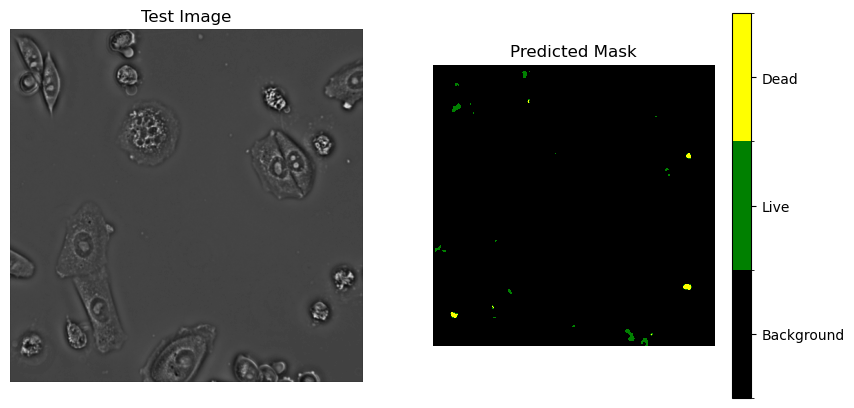

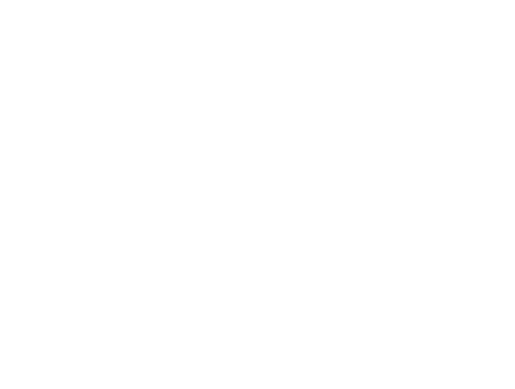

In [59]:
random_index = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[random_index,:, :, 0]
predicted_mask = preds_test_t[random_index].cpu().numpy()
# predicted_mask_1 = preds_test_t[random_index][0].cpu().numpy()
# predicted_mask_2 = preds_test_t[random_index][1].cpu().numpy()

# predicted_mask = np.zeros_like(predicted_mask_1,dtype=np.uint8)
# predicted_mask[predicted_mask_1>0] = [255,255,0]
# predicted_mask[predicted_mask_2>0] = [128,0,128]

#predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

# print(test_image.shape)
# print(predicted_mask.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(test_image, cmap='gray')
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# plt.imshow(predicted_mask)
# plt.title("Predicted Mask")
# print(preds_test_t.shape)

# if predicted_mask.ndim == 1:
#     predicted_mask = predicted_mask.reshape(128, 128)
show_mask(predicted_mask,"Predicted Mask")
plt.axis('off')

plt.show()

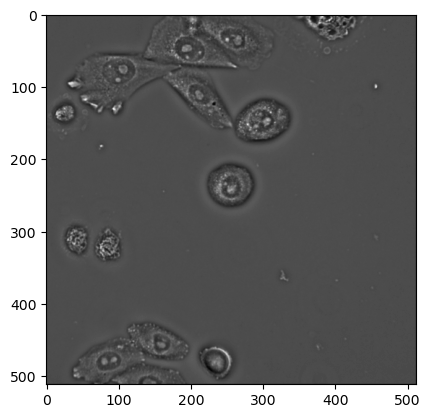

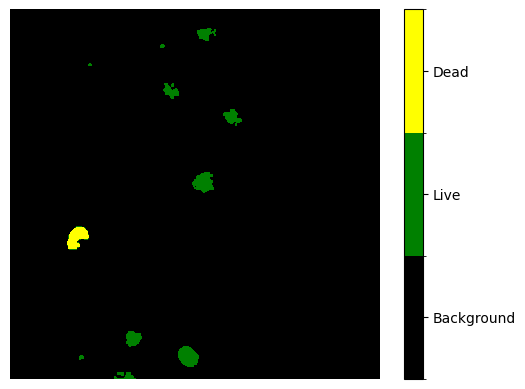

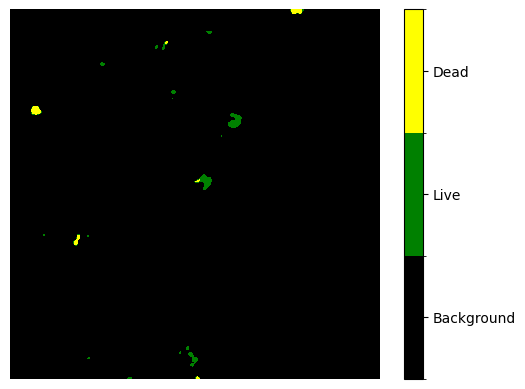

In [60]:


import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    if tensor.shape[0] == 3:
        tensor = np.transpose(tensor, (1, 2, 0))

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

X_val_cpu = x_val
Y_val_cpu = y_val

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t)-1)
predicted_val_mask = preds_val_t[ix].cpu().numpy()
#predicted_val_mask = np.transpose(predicted_val_mask,(1,2,0))

imshow_tensor(X_val_cpu[ix,:,:,0])
#imshow_tensor(Y_val_cpu[ix])
show_mask(Y_val_cpu[ix])
#imshow_tensor(np.squeeze(preds_val[ix]).cpu().astype(np.float32) / 255.0)
show_mask(predicted_val_mask)

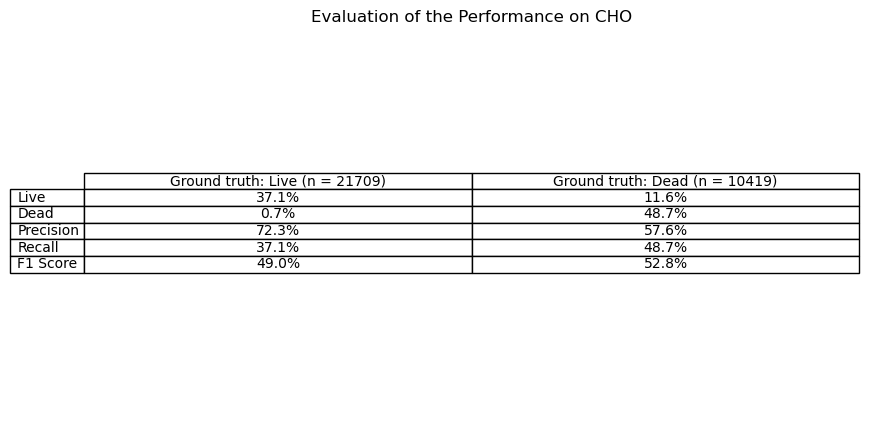

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Define function to calculate pixel-wise confusion matrix metrics


# Assuming Y_val_cpu is the ground truth and preds_val_t is the predicted output
y_true = Y_val_cpu
y_pred = preds_val_t.cpu().numpy()  # Convert to numpy array if necessary

# Calculate metrics
cm, precision, recall, f1 = calculate_metrics(y_true, y_pred)

# Plot confusion matrix and metrics in table form
fig, ax = plt.subplots(figsize=(10, 5))

# Create table content
column_labels = ["Ground truth: Live (n = {})".format(np.sum(y_true == 1)), "Ground truth: Dead (n = {})".format(np.sum(y_true == 2))]
row_labels = ["Live", "Dead", "Precision", "Recall", "F1 Score"]
table_data = [
    [f"{cm[0, 0] / np.sum(y_true == 1) * 100:.1f}%", f"{cm[0, 1] / np.sum(y_true == 2) * 100:.1f}%"],
    [f"{cm[1, 0] / np.sum(y_true == 1) * 100:.1f}%", f"{cm[1, 1] / np.sum(y_true == 2) * 100:.1f}%"],
    [f"{precision[0] * 100:.1f}%", f"{precision[1] * 100:.1f}%"],
    [f"{recall[0] * 100:.1f}%", f"{recall[1] * 100:.1f}%"],
    [f"{f1[0] * 100:.1f}%", f"{f1[1] * 100:.1f}%"]
]

# Create table
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Evaluation of the Performance on CHO")
plt.show()
